In [380]:
import gymnasium
import numpy as np
import matplotlib.pyplot as plt

SEED = 0

env = gymnasium.make('MountainCar-v0', max_episode_steps = 1000)
# car moving along a line, the x-axis, between two "mountains"
# the car has to reach the flag at the top of the right mountain
# the car has to build momentum by driving back and forth between the mountains
# the car has to reach the flag before the episode ends
# https://gymnasium.farama.org/environments/classic_control/mountain_car/

In [381]:
env.reset(seed=SEED) # must reset before using step
# from the gym documentation:
# start position is uniformly random value between -0.6 and -0.4
# start velocity is 0
# use seed to make the start position deterministic

(array([-0.47260767,  0.        ], dtype=float32), {})

In [382]:
# Get the bounds for position and velocity
position_bounds = (env.observation_space.low[0], env.observation_space.high[0])
velocity_bounds = (env.observation_space.low[1], env.observation_space.high[1])

# Define the state bounds
STATE_BOUNDS = [position_bounds, velocity_bounds]

print("Position Bounds:", position_bounds)
print("Velocity Bounds:", velocity_bounds)


Position Bounds: (-1.2, 0.6)
Velocity Bounds: (-0.07, 0.07)


In [383]:
# choose discrete step delta for position and velocity
# to discretize the state space

# seperate
delta_position = 0.1
delta_velocity = 0.01
deltas=[delta_position, delta_velocity]

# use the same
delta=0.1

**NUM_BINS**
- decide the number of bins for each state value
- decides the *granularity* or *resulotion* of the state space

- the more bins, the more states, the finer resolution and capture more details of the state space
- but also increases the size of the Q-table, and the time to train the agent


- the fewer bins, the fewer states, the coarser resolution and capture less details of the state space
- but also decreases the size of the Q-table, and the time to train the agent

In [384]:
# calculate the number of bins for position and velocity based on the bounds and delta
num_bins = [round(STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0] / deltas[i])+1 for i in range(2)]
print("Number of Bins:", num_bins)

Number of Bins: [14, 8]


In [385]:
actions = env.action_space
print(actions)
# so actions are 0, 1, 2
# 0 = accelerate to the left
# 1 = don't accelerate
# 2 = accelerate to the right

Discrete(3)


In [386]:
#notes for myself
# state is a tuple of 2 floats (position, velocity)
# reward is a float (negative for each time step) and 0 at the end (i assume)
# terminated if find end goal
# turnicated if reach max_episode_steps or something else
# info is a dictionary containing extra information about the environment: here nothing
state, reward, terminated, turnicated,info = env.step(0)
# hence 2 ways to be done
done = terminated or turnicated

env.step(0)

(array([-0.47674024, -0.00275165], dtype=float32), -1.0, False, False, {})

so discretize the state: 

from:

&emsp;combination of x poistion and velocity as floats

into:

&emsp;(x,v) where 0<=x<= NUM_BINS[0] and 0<=x<= NUM_BINS[1]

In [387]:
# Discretize the state space
def discretize_state(state, num_bins):
    discretized_state = []
    for i in range(len(state)):
        lower_bound, upper_bound = STATE_BOUNDS[i]
        # make sure the state is within the bounds
        # above the lower bound and below the upper bound
        value = min(max(state[i], lower_bound), upper_bound)
        # discretize the value --> from foat to int
        discretized_value = int((value - lower_bound) / (upper_bound - lower_bound) * num_bins[i])
        discretized_state.append(discretized_value)
    return tuple(discretized_state)
discretize_state(state, num_bins)

(5, 3)

# implement Q-learning

In [388]:
#parameters:
ALPHA = 0.1  # Learning rate
GAMMA = 0.99  # Discount factor
EPSILON = 0.1  # Epsilon-greedy exploration
NUM_EPSISODES = 1000 # Number of episodes

def train_agent_q_learning(env,delta,NUM_EPSISODES=NUM_EPSISODES,ALPHA=ALPHA,GAMMA=GAMMA,EPSILON=EPSILON):
    # Initialize the Q-table
    num_actions = env.action_space.n

    num_bins = [round((STATE_BOUNDS[i][1] - STATE_BOUNDS[i][0]) / delta)+1 for i in range(2)]

    Q = np.zeros(num_bins + [num_actions])  # (num_bins[0], num_bins[1], num_actions)
    
    rewards = []
    
    # Train the agent over NUM_EPSISODES to iterativly improve the Q-table
    for episodes in range(NUM_EPSISODES):
        if episodes % 50 == 0:
            print(episodes)

        # keep track of the total reward obtained in each episode
        total_reward = 0

        # Initialize the state
        state,_=env.reset(seed=SEED)
        done = False

        # Train the agent
        while not done:
            # Discretize the state
            state_discrete = discretize_state(state, num_bins)

            # Epsilon-greedy exploration
            if np.random.random() < EPSILON:
                action = np.random.choice(num_actions)
            else:
                action = np.argmax(Q[state_discrete])

            # Perform the action
            next_state, reward, terminated , turnicated ,_ = env.step(action)

            # update the total reward
            total_reward += reward

            # Check if reached end condition (either goal, or max_episode_steps)
            done = terminated or turnicated
            if done:
                break


            # Discretize the next state
            next_state_discrete = discretize_state(next_state, num_bins)

            # Update the Q-table
            td_target = reward + GAMMA * np.max(Q[next_state_discrete])
            td_error = td_target - Q[state_discrete + (action,)]
            Q[state_discrete + (action,)] += ALPHA * td_error

            # Update the state
            state = next_state
        #after terminated track the reward of this run:
        rewards.append(total_reward)

    return Q,rewards

In [389]:
Q,rewards=train_agent_q_learning(env,0.1) 

0


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


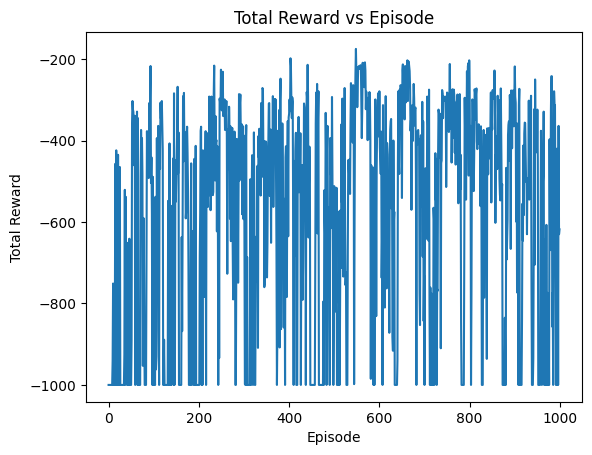

In [390]:
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episode')
plt.show()

eeeeehhhh.... so ser ikke ut som den lærer å komme seg ut hver ang. og ser heller ikke ut som den blir gradvis bedre... ser bare ut som det var helt random når den klarte det og når den ikke klarte det.....